In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [6]:
d, Nobs = 10_000, 12_000
X = sprandn(d, Nobs, 5e-2)
ξ_true = 3*sprandn(d, 5e-3)
ξ_true[1] = 3*randn()
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [7]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [8]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [9]:
mb_size = 250
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress:  35%|██████████████                           |  ETA: 0:12:41

LoadError: [91mInterruptException:[39m

#### Define output scheduler:

In [28]:
A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(3*10^7, 10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [29]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e4)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [30]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 89.25 mins 
20% attempts in 175.2 mins 
30% attempts in 261.59 mins 
40% attempts in 347.51 mins 
50% attempts in 433.07 mins 
60% attempts in 518.72 mins 
70% attempts in 604.47 mins 
80% attempts in 690.63 mins 
90% attempts in 771.89 mins 
100% attempts in 851.31 mins 


* Number of bounces:

In [31]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tcounter-sum(mstate.n_bounces)
@printf("ZZ bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ bounces: 1958295, hyper bounces: 248943

In [32]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.0735746

In [33]:
post_mean_gzz = mstate.mu
# post_median_gzz = median(xi_samples,2);

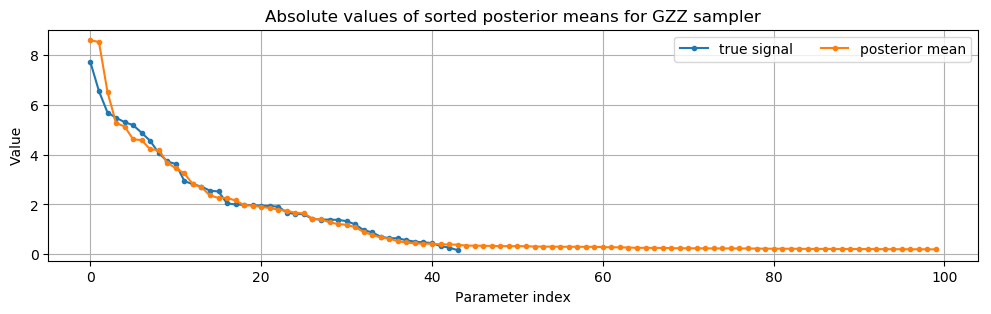

PyObject Text(24.00000000000002, 0.5, 'Value')

In [38]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:100], "o-", markersize=3, label="posterior mean")
# plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Absolute values of sorted posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")

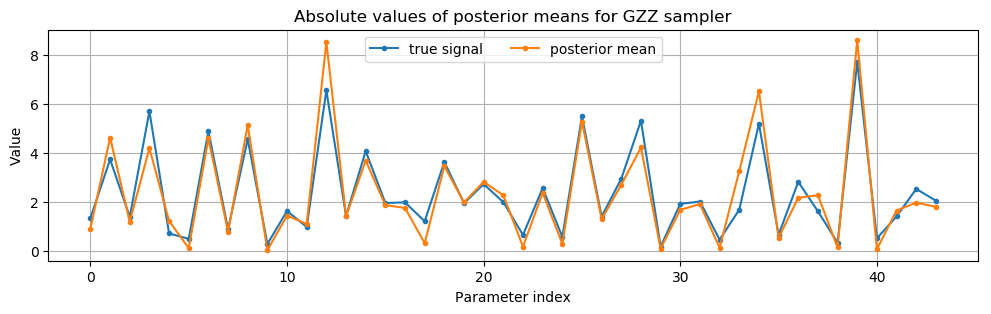

In [39]:
fig = figure(figsize=(12,3))
plot(abs.(ξ_true.nzval), "o-", markersize=3, label="true signal")
plot(vec(abs.(post_mean_gzz))[ξ_true.nzind], "o-", markersize=3, label="posterior mean")
grid(true)
title("Absolute values of posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value");